Si ModuleNotFoundError: No module named 'tqdm' faire !pip install tqdm dans une cellule code

In [1]:
# Import des librairies necessaires pour l'approche ORB + BoVW + SVM,
# l'affichage des resultats et le suivi des ressources
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import joblib
from tqdm import tqdm
import time
import GPUtil
import psutil

In [2]:
# Chemins vers les dossiers contenant les images d'entrainement et de test
TRAIN_PATH = "../dataset/training_set"
TEST_PATH  = "../dataset/test_set"

In [3]:
# Parametres pour l'extraction ORB et la taille du vocabulaire visuel
MAX_FEATURES = 1500   # nombre de points cle ORB
K = 300               # taille du vocabulaire visuel

In [4]:
# Classe pour suivre le temps d'execution et l'utilisation des ressources
# lors des differentes etapes du pipeline ORB + BoVW + SVM
class PerformanceTracker:
    def __init__(self):
        self.start_time = None
        self.logs = {}

    def start(self, name):
        self.start_time = time.time()
        self.cpu_start = psutil.cpu_percent(interval=None)
        self.mem_start = psutil.virtual_memory().used

    def stop(self, name):
        elapsed = time.time() - self.start_time
        cpu = psutil.cpu_percent(interval=None)
        mem = psutil.virtual_memory().used
        self.logs[name] = {
            "time_sec": elapsed,
            "cpu_percent": cpu,
            "ram_mb": mem / 1024**2
        }
        print(f"[{name}] Time: {elapsed:.1f}s | CPU: {cpu}% | RAM: {mem/1024**2:.0f} MB")

In [5]:
# Chargement des chemins des images et des labels a partir des dossiers
# Les classes sont detectees automatiquement a partir des sous-dossiers
def load_images(folder_path):
    image_paths = []
    labels = []
    class_names = sorted(os.listdir(folder_path))

    for label, class_name in enumerate(class_names):
        class_path = os.path.join(folder_path, class_name)
        for img in os.listdir(class_path):
            image_paths.append(os.path.join(class_path, img))
            labels.append(label)

    return image_paths, labels, class_names


train_paths, train_labels, class_names = load_images(TRAIN_PATH)
test_paths, test_labels, _ = load_images(TEST_PATH)

print("Classes :", class_names)
print("Train :", len(train_paths))
print("Test :", len(test_paths))


Classes : ['cats', 'dogs']
Train : 8000
Test : 2000


In [6]:
# Initialisation du detecteur ORB avec les parametres choisis
orb = cv2.ORB_create(
    nfeatures=MAX_FEATURES,
    scaleFactor=1.2,
    nlevels=8
)

In [12]:
# Extraction des descripteurs ORB pour chaque image
# Les images non chargeables ou sans points cle sont ignorees
def extract_orb(paths, labels):
    descriptors = []
    valid_labels = []

    for path, label in tqdm(zip(paths, labels), total=len(paths)):
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue

        kp, des = orb.detectAndCompute(img, None)
        if des is not None:
            descriptors.append(des)
            valid_labels.append(label)

    return descriptors, np.array(valid_labels)


In [13]:
# Extraction des descripteurs ORB pour les images d'entrainement et de test
# avec suivi du temps et de l'utilisation des ressources
tracker = PerformanceTracker()

tracker.start("ORB extraction (train)")
train_des, y_train = extract_orb(train_paths, train_labels)
tracker.stop("ORB extraction (train)")

tracker.start("ORB extraction (test)")
test_des, y_test = extract_orb(test_paths, test_labels)
tracker.stop("ORB extraction (test)")


100%|█████████████████████████████████████████████████████████████████████████████| 8000/8000 [00:53<00:00, 149.25it/s]


[ORB extraction (train)] Time: 53.7s | CPU: 23.1% | RAM: 6709 MB


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:29<00:00, 68.71it/s]

[ORB extraction (test)] Time: 29.1s | CPU: 22.4% | RAM: 6778 MB


In [14]:
# Creation du vocabulaire visuel avec KMeans a partir des descripteurs ORB
# Toutes les features d'entrainement sont regroupees pour l'apprentissage
all_train_des = np.vstack(train_des)

kmeans = MiniBatchKMeans(
    n_clusters=K,
    batch_size=1000,
    random_state=42,
    n_init=10
)

tracker.start("KMeans vocab")
kmeans.fit(all_train_des)
tracker.stop("KMeans vocab")

print("Vocabulaire visuel créé :", K)

[KMeans vocab] Time: 27.5s | CPU: 57.2% | RAM: 4813 MB
Vocabulaire visuel créé : 300


In [15]:
# Construction des histogrammes Bag of Visual Words a partir des descripteurs ORB
# Les histogrammes sont normalises avant l'entrainement du classifieur
def build_histograms(des_list, kmeans, k):
    X = np.zeros((len(des_list), k))
    for i, des in enumerate(des_list):
        words = kmeans.predict(des)
        for w in words:
            X[i, w] += 1
    norm = np.linalg.norm(X, axis=1, keepdims=True) + 1e-8
    return X / norm

tracker.start("BoVW histograms")
X_train = build_histograms(train_des, kmeans, K)
X_test = build_histograms(test_des, kmeans, K)
tracker.stop("BoVW histograms")


print("X_train :", X_train.shape)
print("X_test :", X_test.shape)

[BoVW histograms] Time: 21.2s | CPU: 55.2% | RAM: 5328 MB
X_train : (7987, 300)
X_test : (1997, 300)


In [16]:
# Recherche des meilleurs hyperparametres du SVM avec une validation croisee
param_grid = {
    'C': [10, 50],
    'gamma': ['scale', 0.005]
}

grid = GridSearchCV(
    SVC(kernel='rbf'),
    param_grid,
    cv=3,                
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)

svm = grid.best_estimator_
print("Meilleurs paramètres :", grid.best_params_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Meilleurs paramètres : {'C': 50, 'gamma': 0.005}


In [17]:
# Evaluation finale du modele SVM sur le jeu de test
y_pred = svm.predict(X_test)

print("Accuracy :", accuracy_score(y_test, y_pred))
print("\nRapport de classification :\n")
print(classification_report(y_test, y_pred, target_names=class_names))

Accuracy : 0.6930395593390085

Rapport de classification :

              precision    recall  f1-score   support

        cats       0.71      0.65      0.68       998
        dogs       0.68      0.73      0.71       999

    accuracy                           0.69      1997
   macro avg       0.69      0.69      0.69      1997
weighted avg       0.69      0.69      0.69      1997



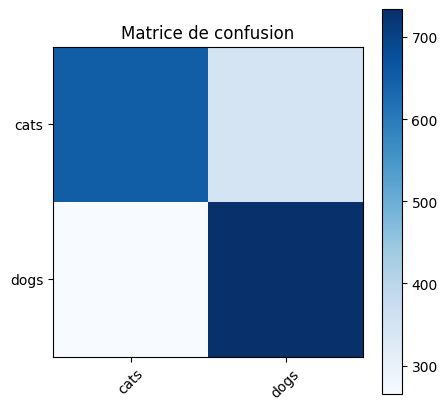

In [18]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,5))
plt.imshow(cm, cmap='Blues')
plt.title("Matrice de confusion")
plt.xticks(range(len(class_names)), class_names, rotation=45)
plt.yticks(range(len(class_names)), class_names)
plt.colorbar()
plt.show()


In [19]:
# Sauvegarde du modele SVM et du vocabulaire visuel 
output_dir = "chekpoints_ORB"

os.makedirs(output_dir, exist_ok=True)

joblib.dump(svm, os.path.join(output_dir, "svm_bovw_orb.pkl"))
joblib.dump(kmeans, os.path.join(output_dir, "kmeans_vocab.pkl"))

print("Modèle sauvegardé")

Modèle sauvegardé


In [20]:
# Chargement du modele SVM et du vocabulaire visuel pour reutilisation
heckpoint_dir = "chekpoints_ORB"

svm = joblib.load(os.path.join(checkpoint_dir, "svm_bovw_orb.pkl"))
kmeans = joblib.load(os.path.join(checkpoint_dir, "kmeans_vocab.pkl"))

# Conclusion
L’approche ORB associée au Bag of Visual Words et à un SVM a permis de construire une chaîne de classification complète basée sur des méthodes classiques de vision par ordinateur. Toutefois, les performances obtenues restent limitées par rapport aux approches de deep learning.

De plus, la construction du vocabulaire visuel par KMeans et l’extraction des descripteurs ORB se sont révélées coûteuses en temps de calcul, notamment dans un contexte d’exécution sur CPU. Ces contraintes computationnelles, combinées à des gains de performance modestes, rendent cette approche peu adaptée à des jeux de données de grande taille.